<a href="https://colab.research.google.com/github/DeepuJose24/DJKeekarikattu/blob/main/Assignment%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries

In [121]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

Reading the data file

In [122]:
df = pd.read_csv("/content/ais_data.csv")
df.head()

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Preprocessing the data**

In [123]:
# Looking for shape;
df.shape

(358351, 10)

In [124]:
# Removing the unneeded column;
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [125]:
# Removing the null values;
df.isnull().sum() 

mmsi                      0
navigationalstatus        0
sog                     458
cog                    3169
heading               20614
shiptype                  0
width                  3711
length                 3743
draught               25543
dtype: int64

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   mmsi                358351 non-null  int64  
 1   navigationalstatus  358351 non-null  object 
 2   sog                 357893 non-null  float64
 3   cog                 355182 non-null  float64
 4   heading             337737 non-null  float64
 5   shiptype            358351 non-null  object 
 6   width               354640 non-null  float64
 7   length              354608 non-null  float64
 8   draught             332808 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 24.6+ MB


In [127]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [128]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 358351
Variables: 9
cat_cols: 2
num_cols: 7
cat_but_car: 0
num_but_cat: 0


In [129]:
df.groupby('mmsi').count().shape

(3894, 8)

In [130]:
# the other important variable
df['navigationalstatus'].value_counts() 

Under way using engine                                   307581
Unknown value                                             17259
Constrained by her draught                                12287
Engaged in fishing                                        10798
Moored                                                     4121
Reserved for future amendment [HSC]                        1872
Restricted maneuverability                                 1868
Under way sailing                                          1396
At anchor                                                   513
Power-driven vessel towing astern                           377
Power-driven vessel pushing ahead or towing alongside       236
Not under command                                            31
Reserved for future amendment [WIG]                          12
Name: navigationalstatus, dtype: int64

In [131]:
def missing_values_table(data):
    m=data.isnull().sum()
    print(pd.DataFrame({'n_miss' : m[m!=0],'ratio' : m[m!=0]/len(data)}))

missing_values_table(df)

         n_miss     ratio
sog         458  0.001278
cog        3169  0.008843
heading   20614  0.057525
width      3711  0.010356
length     3743  0.010445
draught   25543  0.071279


**Checking** **for Outliers**

In [132]:
def thresholds(col, data, d, u):
    q3=data[col].quantile(u)
    q1=data[col].quantile(d)
    down=q1-(q3-q1)*1.5
    up=q1+(q3-q1)*1.5
    return down, up

def check_outliers(col, data, d=0.25, u=0.75, plot=False):
    down, up = thresholds(col, data, d, u)
    ind = data[(data[col] < down) | (data[col] > up)].index
    if plot:
        sns.boxplot(x=col, data=data)
        plt.show()
    if len(ind)!= 0:
        print(f"\n Number of outliers for '{col}' : {len(ind)}")
        return col

for col in num_cols:
    check_outliers(col, df, 0.01, 0.99) # we set thresholds 0.01 and 0.99 !!


 Number of outliers for 'mmsi' : 24

 Number of outliers for 'sog' : 2910

 Number of outliers for 'width' : 9

 Number of outliers for 'length' : 47

 Number of outliers for 'draught' : 567


**Analyzing correlation between variables**

heading  cog      0.961725
length   width    0.956365
dtype: float64


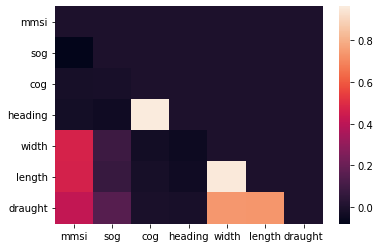

[('heading', 'cog'), ('length', 'width')]

In [133]:
def corr_analyzer(data, corr_th=0.7, plot=False):
    corr_matrix = pd.DataFrame(np.tril(data.corr(), k=-1), columns=data.corr().columns, index=data.corr().columns)
    corr = corr_matrix[corr_matrix>corr_th].stack()
    print(corr)
    if plot: # Görsel olarak analiz
        sns.heatmap(corr_matrix)
        plt.show()
    return corr[corr>corr_th].index.tolist()

corr_analyzer(df, corr_th=0.75, plot=True)

In [134]:
# First, the filling was made according to those in the 'heading' but not in the 'cog'. So we have fewer missings at 'cog'
df['route'] = np.where(df['cog'].isnull(), df['heading'], df['cog']) 

# Secondly, we divided the 360-degree route into 8 regions.
rot= [-1, 45, 90, 135, 180, 225, 270, 315, 360]
df['waypoint'] = pd.cut(df['route'], rot, labels=['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW'])

# Finally, the ships with less than 5.5kts speed and no route information were tagged as 'FIX'.
df['waypoint'] = np.where((df['sog']<5.5) & (df['waypoint'].isnull()), 'FIX', df['waypoint'])

In [135]:
#Vessels’ speed depends on ship type mostly. We fill the missings according to 'sog' and 'route' variables. Then assigned as a new variable.

df['speed'] = df["sog"].fillna(df.groupby(['shiptype', 'waypoint'])['sog'].transform('mean'))

In [136]:
#New aspect for the dimensions;
df['dimension'] = df['width'] * df['length']

In [138]:
#After dropping the duplicates we have a total of 3894 ships. Let’s have a look at the final form of output.
df = df.drop_duplicates(subset='mmsi') # one vessel has more than one data
df.groupby(['shiptype'])['mmsi'].count()

shiptype
Cargo               1716
Dredging              53
Fishing              325
HSC                   27
Law enforcement       20
Military              79
Passenger            123
Pilot                 41
Pleasure             414
Port tender           12
Reserved              12
SAR                  123
Sailing              215
Tanker               642
Towing                11
Towing long/wide       3
Tug                   78
Name: mmsi, dtype: int64

In [139]:
df.head()

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,route,waypoint,speed,dimension
0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN,86.0,ENE,0.0,36.0
1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN,334.5,NNW,0.0,216.0
2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN,208.7,SSW,0.0,44.0
3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN,NaN,FIX,0.0,36.0
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,153.0,SSE,0.0,1287.0


In [140]:
df.drop(['cog','heading','route','sog','mmsi'],axis=1,inplace=True)

In [141]:
df.head()

,navigationalstatus,shiptype,width,length,draught,waypoint,speed,dimension
0,Unknown value,Fishing,4.0,9.0,NaN,ENE,0.0,36.0
1,Unknown value,Port tender,8.0,27.0,NaN,NNW,0.0,216.0
2,Unknown value,Fishing,4.0,11.0,NaN,SSW,0.0,44.0
3,Unknown value,Pleasure,3.0,12.0,NaN,FIX,0.0,36.0
4,Moored,Cargo,13.0,99.0,6.3,SSE,0.0,1287.0


In [142]:
# taking account for the new variables
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations: 3894
Variables: 8
cat_cols: 3
num_cols: 5
cat_but_car: 0
num_but_cat: 0


In [144]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

                                                    navigationalstatus  \
Under way using engine                                            2587   
Unknown value                                                      926   
Moored                                                             130   
Engaged in fishing                                                 100   
Constrained by her draught                                          81   
Restricted maneuverability                                          21   
At anchor                                                           20   
Under way sailing                                                   17   
Reserved for future amendment [HSC]                                  5   
Not under command                                                    3   
Power-driven vessel towing astern                                    2   
Reserved for future amendment [WIG]                                  1   
Power-driven vessel pushing ahead or t

In our dataset, there are rare values in categorical variables. We will group these classes if they are lower than %2 

In [145]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

df = rare_encoder(df, 0.02) # Less than %2 ratio will be grouped


In [146]:
 # combining the 'Unknown value' and 'Rare' groups at 'navigationalstatus' variable
df['status'] = df['navigationalstatus'].where(~((df['navigationalstatus']=='Unknown value') | (df['navigationalstatus']=='Rare')), 'Other')

Since we make new variable from ‘navigationalstatus’, we will disregard this variable. Also if we remember there are high corrrelations between ‘dimension’, ‘width’ and ‘length’. So we will disregard ‘width’ and ‘length’ variables.

In [147]:
df.head()

,navigationalstatus,shiptype,width,length,draught,waypoint,speed,dimension,status
0,Unknown value,Fishing,4.0,9.0,NaN,ENE,0.0,36.0,Other
1,Unknown value,Rare,8.0,27.0,NaN,NNW,0.0,216.0,Other
2,Unknown value,Fishing,4.0,11.0,NaN,SSW,0.0,44.0,Other
3,Unknown value,Pleasure,3.0,12.0,NaN,FIX,0.0,36.0,Other
4,Moored,Cargo,13.0,99.0,6.3,SSE,0.0,1287.0,Moored


In [148]:
df.drop(['navigationalstatus', 'waypoint', 'status'], axis=1, inplace=True)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3894
Variables: 6
cat_cols: 1
num_cols: 5
cat_but_car: 0
num_but_cat: 0


In [149]:
# with rare class
for col in cat_cols:
    cat_summary(df, col)

           shiptype      Ratio
Cargo          1716  44.067797
Tanker          642  16.486903
Pleasure        414  10.631741
Fishing         325   8.346174
Sailing         215   5.521315
Rare            179   4.596816
Passenger       123   3.158706
SAR             123   3.158706
Military         79   2.028762
Tug              78   2.003082
##########################################


In [150]:
# Splitting data as an output and predictors;
y = df['shiptype']
X= df.drop('shiptype', axis=1)

In [151]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [152]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [153]:
X['dimension']=X['dimension'].replace(np.NaN,df['dimension'].mean())
X['draught']=X['draught'].replace(np.NaN,df['draught'].mean())
X['speed']=X['speed'].replace(np.NaN,df['speed'].mean())
X['width']=X['width'].replace(np.NaN,df['width'].mean())
X['length']=X['length'].replace(np.NaN,df['length'].mean())


In [154]:
X.isna().sum()

width        0
length       0
draught      0
speed        0
dimension    0
dtype: int64

In [155]:
df=df.dropna(axis=0)

In [156]:
X.isna().sum()

width        0
length       0
draught      0
speed        0
dimension    0
dtype: int64

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [158]:
target_column=['shiptype']
predictors=list(set(list(df.columns))-set(target_column))
df[predictors]=df[predictors]/df[predictors].max()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
width,2854.0,0.356815,0.186660,0.033333,0.216667,0.300000,0.500000,1.0
length,2854.0,0.224383,0.121403,0.013289,0.146179,0.212625,0.305648,1.0
draught,2854.0,0.261249,0.116946,0.015686,0.188235,0.247059,0.317647,1.0
speed,2854.0,0.207864,0.079373,0.000000,0.175908,0.217973,0.246654,1.0
dimension,2854.0,0.153271,0.156185,0.000668,0.047786,0.095155,0.225564,1.0


In [159]:
X=df[predictors].values
y=df[target_column].values
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.30, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1997, 5)
(857, 5)


In [160]:
df.head(100)

,shiptype,width,length,draught,speed,dimension
4,Cargo,0.216667,0.164452,0.247059,0.000000,0.053759
5,Cargo,0.383333,0.247508,0.247059,0.001912,0.143150
7,Cargo,0.266667,0.249169,0.266667,0.000000,0.100251
8,Cargo,0.266667,0.149502,0.203922,0.000000,0.060150
11,Military,0.200000,0.079734,0.164706,0.000000,0.024060
...,...,...,...,...,...,...
189,Tanker,0.733333,0.415282,0.568627,0.227533,0.459482
195,Passenger,0.433333,0.368771,0.223529,0.313576,0.241103
199,Cargo,0.266667,0.232558,0.184314,0.160612,0.093567
201,Rare,0.133333,0.044850,0.117647,0.000000,0.009023


In [161]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(hidden_layer_sizes=(8,8,8),activation='relu',solver='adam',max_iter=500)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500)

In [162]:
predict_train=mlp.predict(X_train)
predict_test=mlp.predict(X_test)

In [163]:
# Model with Training Data
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[1125    5    0    1    0    5    0    0   37    0]
 [  13   55    0    0    0   12    0    0    0    0]
 [  16   23    0    0    0    9    0    0    0    1]
 [  36   10    0    1    0    7    0    0    0    0]
 [   0    3    0    0    0    4    0    0    0    0]
 [  23   26    0    1    0   45    0    0    0    0]
 [   0    2    0    0    0   11    0    0    0    0]
 [   2    4    0    0    0    0    0    0    0    0]
 [ 347    1    0    0    0    0    0    0  117    0]
 [   7   40    0    0    0    7    0    0    0    1]]
              precision    recall  f1-score   support

       Cargo       0.72      0.96      0.82      1173
     Fishing       0.33      0.69      0.44        80
    Military       0.00      0.00      0.00        49
   Passenger       0.33      0.02      0.04        54
    Pleasure       0.00      0.00      0.00         7
        Rare       0.45      0.47      0.46        95
         SAR       0.00      0.00      0.00        13
     Sailing       0.00      0.00   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt=DecisionTreeClassifier(random_state=42)

In [ ]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
#Predict the response for test dataset
y_pred = dt.predict(X_test)

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6244653550042771


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       Cargo       0.79      0.81      0.80       484
     Fishing       0.52      0.53      0.52        95
    Military       0.39      0.52      0.45        21
   Passenger       0.35      0.35      0.35        40
    Pleasure       0.46      0.53      0.50       129
        Rare       0.34      0.33      0.34        63
         SAR       0.39      0.37      0.38        38
     Sailing       0.36      0.24      0.29        68
      Tanker       0.68      0.63      0.65       206
         Tug       0.48      0.52      0.50        25

    accuracy                           0.62      1169
   macro avg       0.48      0.48      0.48      1169
weighted avg       0.62      0.62      0.62      1169



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[393   2   5  15   1  10   0   0  54   4]
 [  7  50   2   2  14   7   4   6   0   3]
 [  3   0  11   1   1   2   3   0   0   0]
 [ 13   1   0  14   4   4   1   0   2   1]
 [  0  24   0   2  69   7   9  16   0   2]
 [  7   7   5   1   7  21   4   4   4   3]
 [  0   4   2   0  13   4  14   1   0   0]
 [  4   5   0   1  39   2   1  16   0   0]
 [ 70   0   2   2   0   2   0   0 129   1]
 [  1   4   1   2   1   2   0   1   0  13]]


## Plotting decision trees

In [ ]:
print(dt.predict(X.sample(1)))

['Sailing']


In [ ]:
!pip install graphviz
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import tree


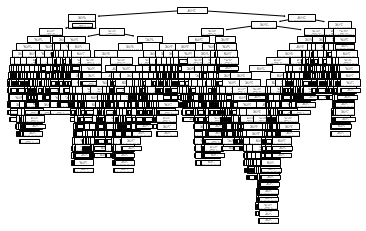

In [ ]:

tree.plot_tree(dt);


**RandomForest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200,criterion="entropy",bootstrap=True)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       Cargo       0.74      0.92      0.82       484
     Fishing       0.53      0.57      0.55        95
    Military       0.35      0.29      0.32        21
   Passenger       0.36      0.20      0.26        40
    Pleasure       0.45      0.53      0.49       129
        Rare       0.41      0.33      0.37        63
         SAR       0.35      0.34      0.35        38
     Sailing       0.36      0.24      0.29        68
      Tanker       0.80      0.50      0.61       206
         Tug       0.63      0.48      0.55        25

    accuracy                           0.64      1169
   macro avg       0.50      0.44      0.46      1169
weighted avg       0.63      0.64      0.62      1169

[[445   3   0   5   0   6   1   0  24   0]
 [  8  54   0   2  15   3   3   7   1   2]
 [  6   1   6   0   0   7   1   0   0   0]
 [ 19   2   2   8   4   4   0   1   0   0]
 [  1  17   2   2  69   5  14  18   0   1]
 [ 13   7   4   2   7  21 

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       Cargo       0.60      0.98      0.74       484
     Fishing       0.46      0.34      0.39        95
    Military       0.17      0.05      0.07        21
   Passenger       0.00      0.00      0.00        40
    Pleasure       0.42      0.79      0.55       129
        Rare       0.43      0.10      0.16        63
         SAR       0.27      0.11      0.15        38
     Sailing       1.00      0.01      0.03        68
      Tanker       0.25      0.01      0.02       206
         Tug       0.16      0.12      0.14        25

    accuracy                           0.54      1169
   macro avg       0.38      0.25      0.23      1169
weighted avg       0.47      0.54      0.42      1169

[[476   3   1   0   0   2   0   0   1   1]
 [ 17  32   0   0  40   1   1   0   1   3]
 [ 15   0   1   0   1   1   0   0   1   2]
 [ 24   4   0   0   9   1   0   0   1   1]
 [  3  15   1   0 102   0   5   0   0   3]
 [ 36   2   3   0   7   6 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

**Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
#fit the model with the training data
model.fit(X_train,y_train)
#predict the target on the train dataset
predict_train=model.predict(X_train)
#predict the target on the test dataset
predict_test=model.predict(X_test)
print('Target on test data',predict_test)

Target on test data ['Fishing' 'Pleasure' 'Tug' ... 'Tanker' 'Tug' 'Sailing']


**SVM**

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
confusion_matrix(y_test,y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[472,   1,   0,   0,   6,   1,   0,   0,   2,   2],
       [ 18,  25,   0,   0,  45,   0,   1,   0,   3,   3],
       [ 18,   0,   2,   0,   1,   0,   0,   0,   0,   0],
       [ 24,   0,   1,   0,  13,   1,   0,   0,   1,   0],
       [  3,   1,   1,   0, 117,   0,   5,   0,   0,   2],
       [ 40,   1,   4,   0,   9,   1,   2,   0,   1,   5],
       [  7,   0,   0,   0,  25,   0,   4,   0,   1,   1],
       [  1,   0,   0,   0,  66,   0,   1,   0,   0,   0],
       [201,   0,   1,   0,   0,   1,   0,   0,   3,   0],
       [ 15,   1,   2,   0,   2,   0,   0,   0,   1,   4]])

In [ ]:
print("Accuracy score  %.4f" %metrics.accuracy_score(y_test, y_pred))

Accuracy score  0.5372
